In [43]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import geopandas as gp
import plotly.express as px
import skill_metrics as sm
import skill_metrics as sm
import matplotlib.pyplot as plt
import scipy.stats as scs
import plotly.graph_objects as go
sys.path.append(r'C:\Users\Pooya\w\GitHub\ShiraziPooya\DroughtMonitoringIran')
from app.utils.model_evaluator import ModelEvaluator

### Load Monthly Data

In [44]:
DATABASE_PATH = "../database/database.db"
conn = sqlite3.connect(DATABASE_PATH)
data = pd.read_sql(sql='SELECT * FROM data', con=conn)
conn.close()

### Columns

In [45]:
data.columns.to_list()

['region_id',
 'region_name',
 'station_name',
 'station_id',
 'lat',
 'lon',
 'station_elevation',
 'date',
 'tmax',
 'tmin',
 'tm',
 'rrr24',
 'Hargreaves',
 'SPI_1',
 'SPEI_1',
 'SPI_3',
 'SPEI_3',
 'SPI_6',
 'SPEI_6',
 'SPI_9',
 'SPEI_9',
 'SPI_12',
 'SPEI_12',
 'SPI_15',
 'SPEI_15',
 'SPI_18',
 'SPEI_18',
 'SPI_21',
 'SPEI_21',
 'SPI_24',
 'SPEI_24',
 'CHIRPS',
 'ERA5',
 'GPM',
 'PERSIANN_CDR',
 'TRMM',
 'TerraClimate',
 'MOD16A2GF',
 'EVI_Aqua_MYD13A3',
 'EVI_Terra_MOD13A3',
 'LST_Day_Aqua_MYD21C3',
 'LST_Day_Terra_MOD21C3',
 'LST_Night_Aqua_MYD21C3',
 'LST_Night_Terra_MOD21C3',
 'NDVI_Aqua_MYD13A3',
 'NDVI_Terra_MOD13A3',
 'NDVI',
 'EVI',
 'LST_Day',
 'LST_Night',
 'LST',
 'PCI_ERA5',
 'PCI_GPM',
 'PCI_TRMM',
 'PCI_TerraClimate',
 'PCI_PERSIANN_CDR',
 'PCI_CHIRPS',
 'VCI',
 'TCI',
 'TCI_Day',
 'TCI_Night',
 'VHI',
 'VHI_Day',
 'VHI_Night',
 'CI_GPM',
 'CI_ERA5',
 'CI_TRMM',
 'CI_TerraClimate',
 'CI_PERSIANN_CDR',
 'CI_CHIRPS',
 'CHIRPS_SPI_1',
 'CHIRPS_SPEI_1',
 'ERA5_SPI_1',
 '

In [46]:
SELECTED_COLUMNS = [
    'region_id',
    'region_name',
    'station_name',
    'station_id',
    'lat',
    'lon',
    'station_elevation',
    'date',
    'rrr24',
    'CHIRPS',
    'ERA5',
    'GPM',
    'PERSIANN_CDR',
    'TRMM',
    'TerraClimate'
]

### Unique Station

In [47]:
data[[
    'region_id',
    'region_name',
    'station_name',
    'station_id'
]].drop_duplicates().reset_index(drop=True)

,region_id,region_name,station_name,station_id
0,MASA,Mazandaran,Ramsar,40732
1,MASA,Mazandaran,Nowshahr,40734
2,MASA,Mazandaran,Siahbisheh,40735
3,MASA,Mazandaran,Babolsar,40736
4,MASA,Mazandaran,Gharakhil,40737
5,MASA,Mazandaran,Sari,40759
6,MASA,Mazandaran,Kiyasar,40760
7,MASA,Mazandaran,Sari (Dasht-E-Naz Airport),40788
8,MASA,Mazandaran,Galugah,99299
9,MASA,Mazandaran,Bandar-E-Amirabad,99306


### Select Regions and Stations
- Cluster 1 - Sari:40759
- Cluster 2 - Alasht:99361  
- Cluster 3 - Ramsar:40732

In [48]:
SELECTED_REGIONS = ["Mazandaran"]
SELECTED_STATIONS = ["Sari", "Alasht", "Ramsar"]

### Selected Date Range

In [49]:
START_DATE = "2005-09"
END_DATE = "2024-09"

## Filter Data

In [50]:
selected_data = data \
    .query('region_name == @SELECTED_REGIONS') \
        .query('station_name == @SELECTED_STATIONS') \
            .query("date >= @START_DATE and date < @END_DATE") \
                .filter(items=SELECTED_COLUMNS)

selected_data

,region_id,region_name,station_name,station_id,lat,lon,station_elevation,date,rrr24,CHIRPS,ERA5,GPM,PERSIANN_CDR,TRMM,TerraClimate
308,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-09,36.52,39.526,133.814,47.520,17.753,33.949,62.0
309,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-10,116.10,90.368,331.979,107.136,34.573,87.828,146.0
310,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-11,61.22,134.801,167.927,100.800,56.969,93.468,144.0
311,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-12,54.13,162.861,123.151,55.056,45.104,61.831,75.0
312,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2006-01,78.12,179.211,221.942,101.928,99.951,115.673,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8217,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-04,48.61,43.919,112.908,36.000,38.501,NaN,33.0
8218,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-05,49.11,52.236,191.930,52.080,52.798,NaN,24.0
8219,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-06,158.21,57.173,99.149,59.760,41.765,NaN,11.0
8220,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-07,52.81,40.035,67.956,14.880,4.405,NaN,8.0


### TaylorDiagram Precip (for each station)

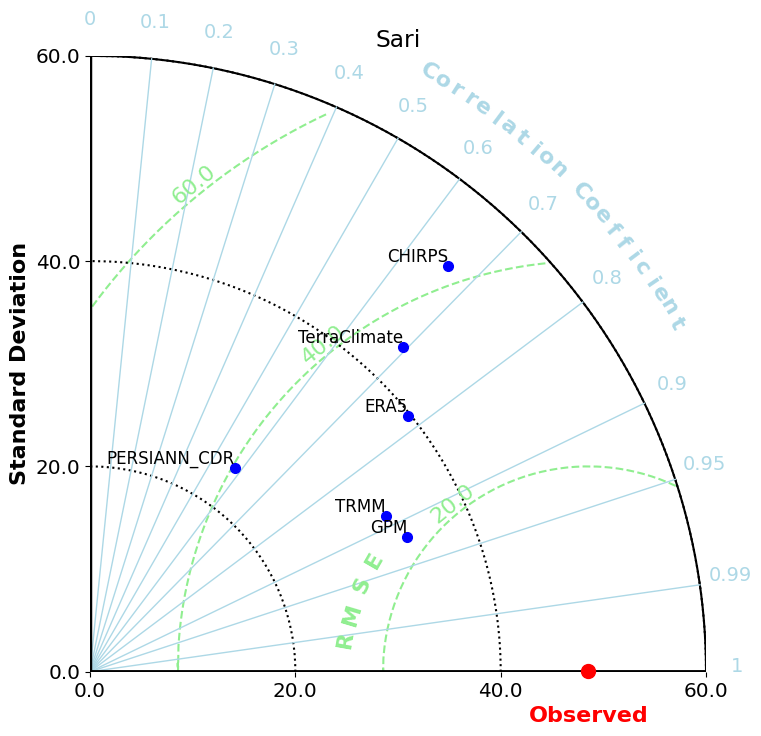

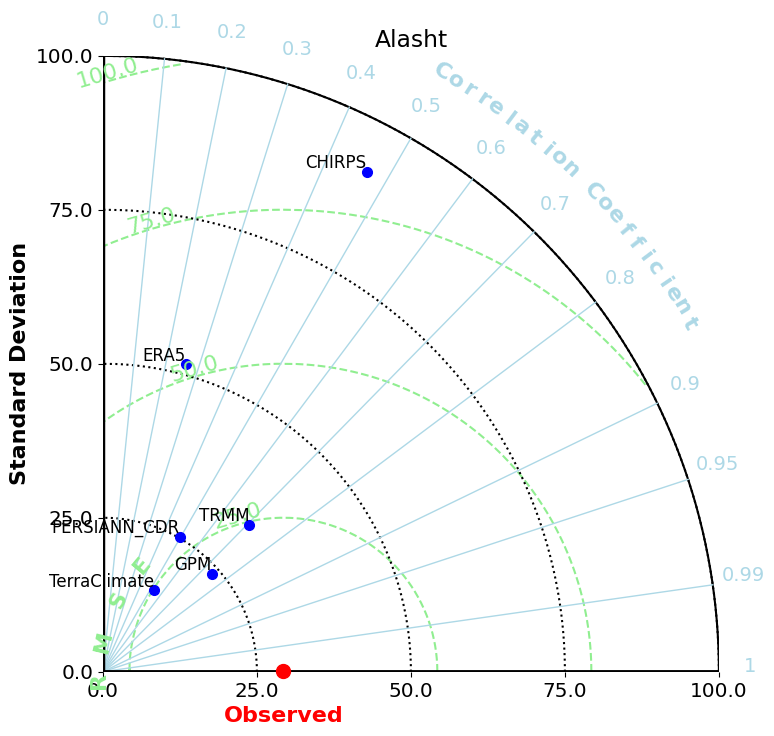

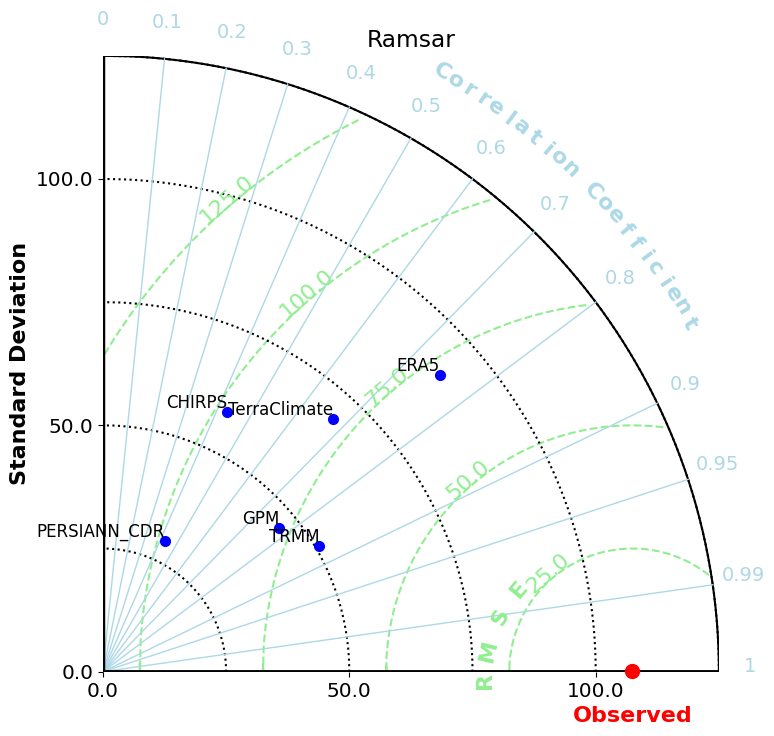

In [51]:
for sti in SELECTED_STATIONS:
    df = selected_data.query(f"station_name == '{sti}'")
    
    observed_name = 'rrr24'
    models_name = ['CHIRPS', 'ERA5', 'GPM', 'TRMM', 'TerraClimate', 'PERSIANN_CDR']
    
    std_mods = []
    correlations = []
    rmses = []
    std_obss = []

    for model in models_name:
        valid_data = df[[observed_name, model]].dropna()
        
        observed_values = valid_data[observed_name].values
        modeled_values = valid_data[model].values

        std_mod = np.std(modeled_values)
        std_obs = np.std(observed_values)
        cor = np.corrcoef(observed_values, modeled_values)[0, 1]
        rmse = np.sqrt(np.mean((observed_values - modeled_values) ** 2))
        
        std_mods.append(std_mod)
        std_obss.append(std_obs)
        correlations.append(cor)
        rmses.append(rmse)

    std_mods.insert(0, np.std(df['rrr24'].dropna()))
    rmses.insert(0, 0)
    correlations.insert(0, 1)

    std_mods = np.array(std_mods)
    correlations = np.array(correlations)
    rmses = np.array(rmses)
    std_obss = np.array(std_obss)

    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=(8, 8))
    sm.taylor_diagram(
        std_mods, rmses, correlations,
        markerdisplayed='marker',
        markerLabel=['Observed'] + models_name,
        markerColor='blue',
        markerSize=14,
        colCOR='lightblue',
        colrms='lightgreen',
        colstd='black',
        styleCOR='-',
        widthCOR=1,
        titleOBS='Observed',
        # styleOBS='-',
        colOBS='red',
        labelrms="RMSE",
        markerobs = 'o'
    )
    # plt.legend(loc="upper right")
    plt.title(f"{sti}")
    plt.show()

### Calculate Model Evaluator

In [52]:
for pr_model in models_name:
    for sid, df in data.query("station_name in @SELECTED_STATIONS").groupby(by='station_name'):
        print(f"\nMetrics for Station ID: {sid} and Precip Model: {pr_model}")
        ModelEvaluator(df, observed_name, pr_model).display_metrics()


Metrics for Station ID: Alasht and Precip Model: CHIRPS
Model Performance Metrics:
Mean Absolute Error (MAE): 76.8667
Mean Squared Error (MSE): 11565.5956
Root Mean Squared Error (RMSE): 107.5435
R-squared (R2): -13.1431
Explained Variance Score: -7.2220
Willmott's Index of Agreement (WI): 0.2364
Nash–Sutcliffe Efficiency (NS): -13.1431
Mean Absolute Deviation (MAD): 76.8667

Metrics for Station ID: Ramsar and Precip Model: CHIRPS
Model Performance Metrics:
Mean Absolute Error (MAE): 62.6146
Mean Squared Error (MSE): 10910.7078
Root Mean Squared Error (RMSE): 104.4543
R-squared (R2): 0.0554
Explained Variance Score: 0.0810
Willmott's Index of Agreement (WI): 0.4859
Nash–Sutcliffe Efficiency (NS): 0.0554
Mean Absolute Deviation (MAD): 62.6146

Metrics for Station ID: Sari and Precip Model: CHIRPS
Model Performance Metrics:
Mean Absolute Error (MAE): 33.8252
Mean Squared Error (MSE): 2079.8203
Root Mean Squared Error (RMSE): 45.6050
R-squared (R2): 0.0784
Explained Variance Score: 0.176

In [53]:
for st in SELECTED_STATIONS:
    station_data = data.query("station_name == @st")[['date', 'rrr24', 'GPM']].dropna()

    fig = px.scatter(
        station_data,
        x='rrr24',
        y='GPM',
        labels={
            "rrr24": f"{st}<br>Observed Precipitation (mm)",
            "GPM": "GPM Estimated Precipitation (mm)"
        },
        opacity=0.7,
        color_discrete_sequence=["black"],
    )

    fig.update_traces(marker=dict(size=8, color="black"))

    max_limit = max(station_data['rrr24'].max(),
                    station_data['GPM'].max()) + 50
    
    tick_vals = np.arange(0, max_limit + 1, 50)

    fig.update_layout(
        xaxis=dict(range=[0, max_limit], tickvals=tick_vals),
        yaxis=dict(range=[0, max_limit], tickvals=tick_vals),
        width=600,
        height=600,
        title=None,
        margin=dict(l=20, r=20, t=20, b=20),
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)

    fig.add_trace(go.Scatter(
        x=[0, max_limit],
        y=[0, max_limit],
        mode="lines",
        line=dict(color="red", dash="dash"),
        showlegend=False
    ))

    fig.show()


# Ensemble Precipitation Models

In [54]:
selected_data = data \
    .query('region_name == @SELECTED_REGIONS') \
        .query("date >= @START_DATE and date < @END_DATE") \
            .filter(items=SELECTED_COLUMNS)

selected_data

,region_id,region_name,station_name,station_id,lat,lon,station_elevation,date,rrr24,CHIRPS,ERA5,GPM,PERSIANN_CDR,TRMM,TerraClimate
308,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-09,36.52,39.526,133.814,47.520,17.753,33.949,62.0
309,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-10,116.10,90.368,331.979,107.136,34.573,87.828,146.0
310,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-11,61.22,134.801,167.927,100.800,56.969,93.468,144.0
311,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2005-12,54.13,162.861,123.151,55.056,45.104,61.831,75.0
312,MASA,Mazandaran,Ramsar,40732,36.90,50.68,-20.0,2006-01,78.12,179.211,221.942,101.928,99.951,115.673,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8217,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-04,48.61,43.919,112.908,36.000,38.501,NaN,33.0
8218,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-05,49.11,52.236,191.930,52.080,52.798,NaN,24.0
8219,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-06,158.21,57.173,99.149,59.760,41.765,NaN,11.0
8220,MASA,Mazandaran,Alasht,99361,36.07,52.84,1805.0,2024-07,52.81,40.035,67.956,14.880,4.405,NaN,8.0


### Convert Date Column to datetime

In [55]:
selected_data['date'] = pd.to_datetime(selected_data['date'])
selected_data.head()

,region_id,region_name,station_name,station_id,lat,lon,station_elevation,date,rrr24,CHIRPS,ERA5,GPM,PERSIANN_CDR,TRMM,TerraClimate
308,MASA,Mazandaran,Ramsar,40732,36.9,50.68,-20.0,2005-09-01,36.52,39.526,133.814,47.520,17.753,33.949,62.0
309,MASA,Mazandaran,Ramsar,40732,36.9,50.68,-20.0,2005-10-01,116.10,90.368,331.979,107.136,34.573,87.828,146.0
310,MASA,Mazandaran,Ramsar,40732,36.9,50.68,-20.0,2005-11-01,61.22,134.801,167.927,100.800,56.969,93.468,144.0
311,MASA,Mazandaran,Ramsar,40732,36.9,50.68,-20.0,2005-12-01,54.13,162.861,123.151,55.056,45.104,61.831,75.0
312,MASA,Mazandaran,Ramsar,40732,36.9,50.68,-20.0,2006-01-01,78.12,179.211,221.942,101.928,99.951,115.673,108.0


### Define Precipitation Models

In [56]:
precip_models = ['CHIRPS', 'ERA5', 'GPM', 'PERSIANN_CDR', 'TRMM', 'TerraClimate']
observed_col = 'rrr24'

### Calculate Weights Based on Correlation

In [57]:
# Calculate correlation-based weights for each model
correlations = []
for model in precip_models:
    valid_data = selected_data[[observed_col, model]].dropna()
    corr = valid_data[observed_col].corr(valid_data[model])
    correlations.append(max(0, corr))  # Ensure non-negative weights

# Normalize weights to sum to 1
total_corr = sum(correlations)
weights = [c / total_corr for c in correlations]

# Display weights
weights_df = pd.DataFrame({
    'Model': precip_models,
    'Correlation': correlations,
    'Weight': weights
})
weights_df

,Model,Correlation,Weight
0,CHIRPS,0.356982,0.101433
1,ERA5,0.563768,0.160189
2,GPM,0.754673,0.214433
3,PERSIANN_CDR,0.448171,0.127343
4,TRMM,0.669585,0.190256
5,TerraClimate,0.726216,0.206347


### Create Weighted Ensemble Model

In [59]:
# Create ensemble prediction
selected_data['Ensemble_Weighted'] = sum(
    selected_data[model] * weight 
    for model, weight in zip(precip_models, weights)
)

# Display sample of results
selected_data[['date', 'station_name', observed_col] + precip_models + ['Ensemble_Weighted']]

,date,station_name,rrr24,CHIRPS,ERA5,GPM,PERSIANN_CDR,TRMM,TerraClimate,Ensemble_Weighted
308,2005-09-01,Ramsar,36.52,39.526,133.814,47.520,17.753,33.949,62.0,57.147801
309,2005-10-01,Ramsar,116.10,90.368,331.979,107.136,34.573,87.828,146.0,136.558120
310,2005-11-01,Ramsar,61.22,134.801,167.927,100.800,56.969,93.468,144.0,116.939463
311,2005-12-01,Ramsar,54.13,162.861,123.151,55.056,45.104,61.831,75.0,81.036058
312,2006-01-01,Ramsar,78.12,179.211,221.942,101.928,99.951,115.673,108.0,132.608172
...,...,...,...,...,...,...,...,...,...,...
8217,2024-04-01,Alasht,48.61,43.919,112.908,36.000,38.501,NaN,33.0,NaN
8218,2024-05-01,Alasht,49.11,52.236,191.930,52.080,52.798,NaN,24.0,NaN
8219,2024-06-01,Alasht,158.21,57.173,99.149,59.760,41.765,NaN,11.0,NaN
8220,2024-07-01,Alasht,52.81,40.035,67.956,14.880,4.405,NaN,8.0,NaN


### Evaluate Ensemble Model Performance

In [60]:
# Calculate metrics for all models including ensemble
all_models = precip_models + ['Ensemble_Weighted']
metrics_results = []

for model in all_models:
    valid_data = selected_data[[observed_col, model]].dropna()
    
    observed = valid_data[observed_col].values
    predicted = valid_data[model].values
    
    # Calculate metrics
    correlation = np.corrcoef(observed, predicted)[0, 1]
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    mae = np.mean(np.abs(observed - predicted))
    bias = np.mean(predicted - observed)
    
    # R-squared
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Standard deviation
    std_obs = np.std(observed)
    std_pred = np.std(predicted)
    
    metrics_results.append({
        'Model': model,
        'Correlation': correlation,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Bias': bias,
        'STD_Obs': std_obs,
        'STD_Pred': std_pred
    })

metrics_df = pd.DataFrame(metrics_results)
metrics_df = metrics_df.round(4)
metrics_df

,Model,Correlation,R²,RMSE,MAE,Bias,STD_Obs,STD_Pred
0,CHIRPS,0.3570,-1.1888,86.1138,54.9855,35.1372,58.2065,77.5653
1,ERA5,0.5638,-0.3124,66.6807,47.4890,36.1065,58.2065,61.6501
2,GPM,0.7547,0.5265,40.0541,23.3379,-6.1650,58.2065,33.5395
3,PERSIANN_CDR,0.4482,0.0467,56.8312,33.7554,-22.8395,58.2065,26.8948
4,TRMM,0.6696,0.4419,44.8204,28.0038,-4.5435,59.9981,41.7187
5,TerraClimate,0.7262,0.4637,42.6256,26.5710,-13.1030,58.2065,48.9080
6,Ensemble_Weighted,0.7543,0.5525,40.1362,25.6845,2.1675,59.9981,37.8607


### Visualize Model Performance Comparison

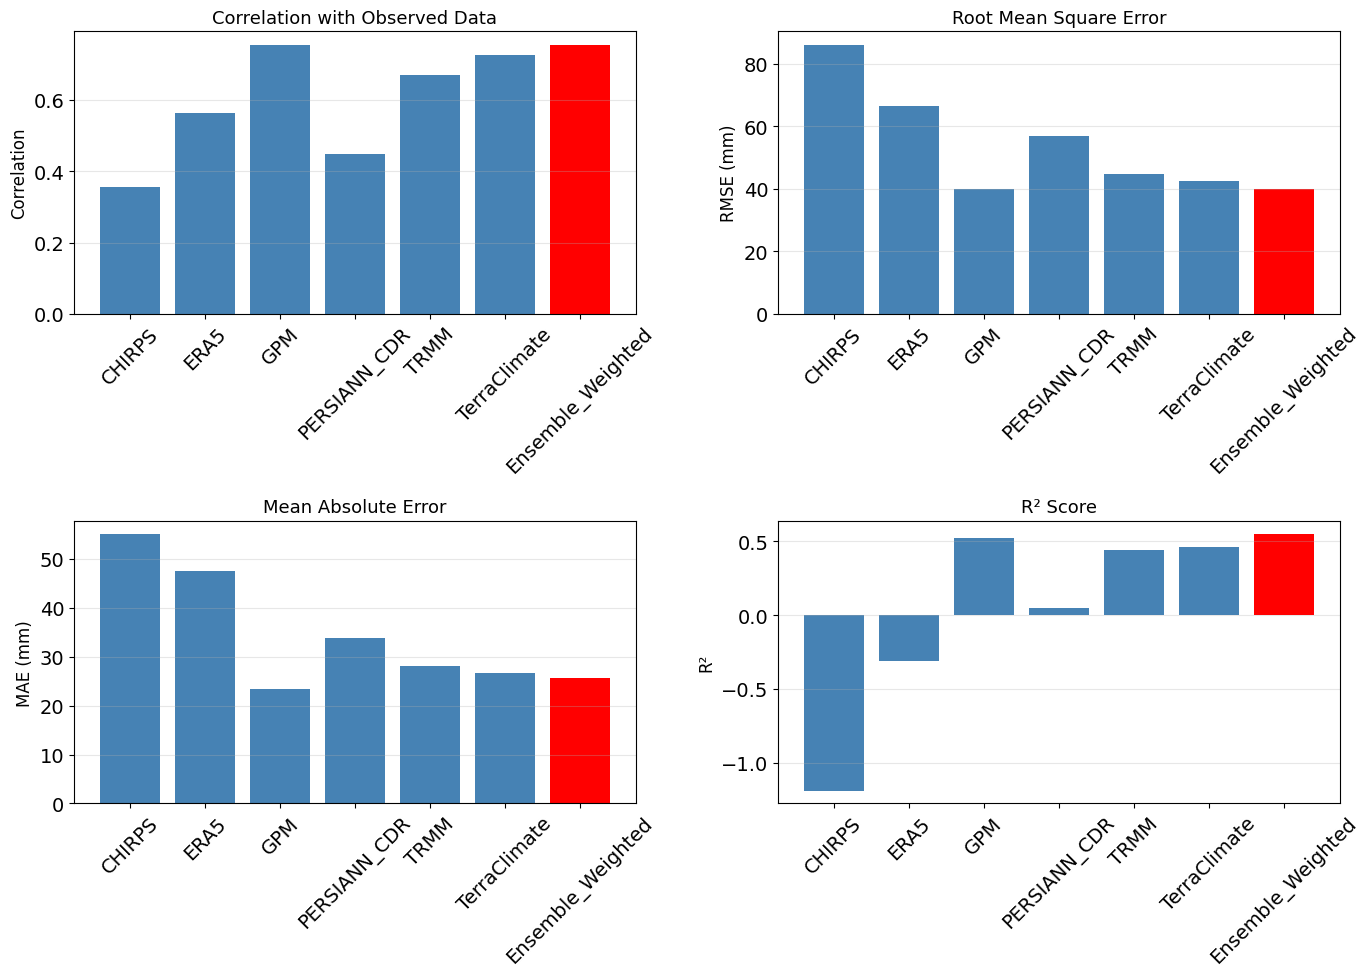

In [61]:
# Create bar plots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Correlation
axes[0, 0].bar(metrics_df['Model'], metrics_df['Correlation'], color=['steelblue']*6 + ['red'])
axes[0, 0].set_ylabel('Correlation', fontsize=12)
axes[0, 0].set_title('Correlation with Observed Data', fontsize=13)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# RMSE (lower is better)
axes[0, 1].bar(metrics_df['Model'], metrics_df['RMSE'], color=['steelblue']*6 + ['red'])
axes[0, 1].set_ylabel('RMSE (mm)', fontsize=12)
axes[0, 1].set_title('Root Mean Square Error', fontsize=13)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# MAE (lower is better)
axes[1, 0].bar(metrics_df['Model'], metrics_df['MAE'], color=['steelblue']*6 + ['red'])
axes[1, 0].set_ylabel('MAE (mm)', fontsize=12)
axes[1, 0].set_title('Mean Absolute Error', fontsize=13)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# R²
axes[1, 1].bar(metrics_df['Model'], metrics_df['R²'], color=['steelblue']*6 + ['red'])
axes[1, 1].set_ylabel('R²', fontsize=12)
axes[1, 1].set_title('R² Score', fontsize=13)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Taylor Diagram with Ensemble Model

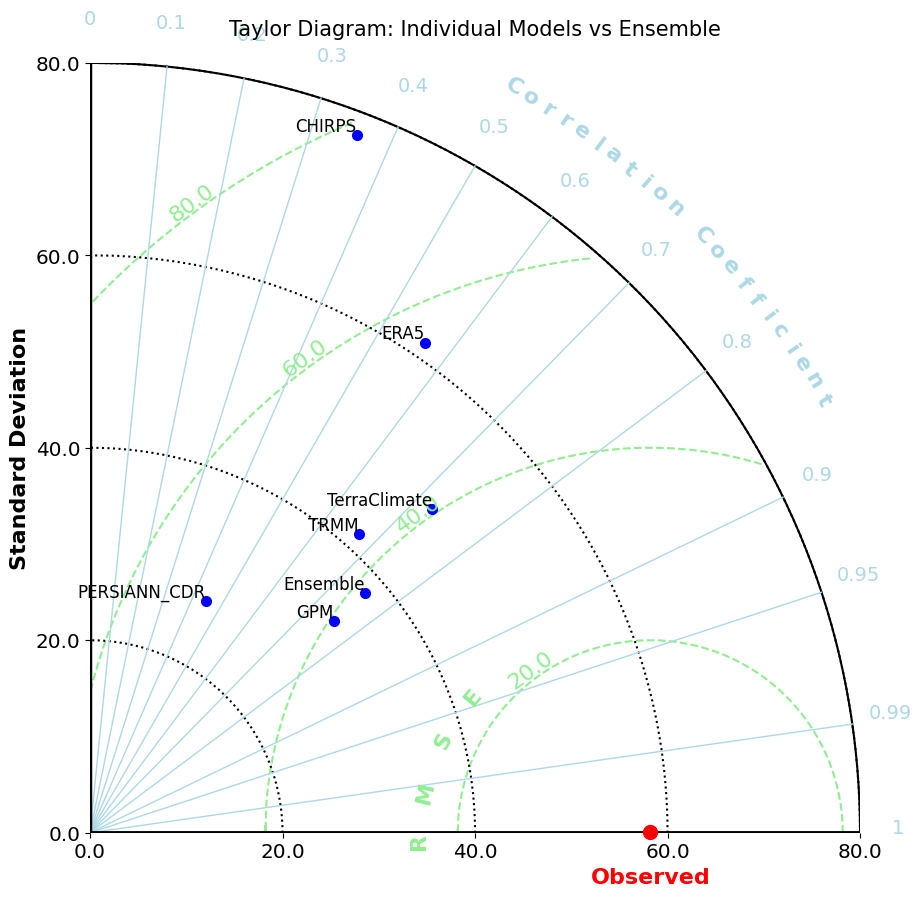

In [65]:
# Prepare data for Taylor diagram
std_mods = []
correlations_td = []
rmses_td = []

for model in all_models:
    valid_data = selected_data[[observed_col, model]].dropna()
    
    observed_values = valid_data[observed_col].values
    modeled_values = valid_data[model].values
    
    std_mod = np.std(modeled_values)
    cor = np.corrcoef(observed_values, modeled_values)[0, 1]
    rmse = np.sqrt(np.mean((observed_values - modeled_values) ** 2))
    
    std_mods.append(std_mod)
    correlations_td.append(cor)
    rmses_td.append(rmse)

# Add observed data
std_mods.insert(0, np.std(selected_data[observed_col].dropna()))
rmses_td.insert(0, 0)
correlations_td.insert(0, 1)

std_mods = np.array(std_mods)
correlations_td = np.array(correlations_td)
rmses_td = np.array(rmses_td)

# Create Taylor diagram
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10, 10))

marker_labels = ['Observed'] + precip_models + ['Ensemble']

sm.taylor_diagram(
    std_mods, rmses_td, correlations_td,
    markerdisplayed='marker',
    markerLabel=marker_labels,
    markerColor='blue',
    markerSize=14,
    colCOR='lightblue',
    colrms='lightgreen',
    colstd='black',
    styleCOR='-',
    widthCOR=1,
    titleOBS='Observed',
    colOBS='red',
    labelrms="RMSE",
    markerobs='o'
)
plt.title("Taylor Diagram: Individual Models vs Ensemble", fontsize=15, pad=20)
plt.show()

### Scatter Plot: Observed vs Ensemble

In [63]:
# Scatter plot for ensemble model
ensemble_data = selected_data[[observed_col, 'Ensemble_Weighted']].dropna()

fig = px.scatter(
    ensemble_data,
    x=observed_col,
    y='Ensemble_Weighted',
    labels={
        observed_col: "Observed Precipitation (mm)",
        "Ensemble_Weighted": "Ensemble Predicted Precipitation (mm)"
    },
    opacity=0.7,
    color_discrete_sequence=["darkred"],
)

fig.update_traces(marker=dict(size=8))

max_limit = max(ensemble_data[observed_col].max(),
                ensemble_data['Ensemble_Weighted'].max()) + 50

tick_vals = np.arange(0, max_limit + 1, 50)

fig.update_layout(
    xaxis=dict(range=[0, max_limit], tickvals=tick_vals),
    yaxis=dict(range=[0, max_limit], tickvals=tick_vals),
    width=700,
    height=700,
    title="Observed vs Ensemble Model Predictions",
    margin=dict(l=20, r=20, t=40, b=20),
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)

# Add 1:1 line
fig.add_trace(go.Scatter(
    x=[0, max_limit],
    y=[0, max_limit],
    mode="lines",
    line=dict(color="red", dash="dash"),
    name="1:1 Line",
    showlegend=True
))

fig.show()

### Model Performance Summary

In [64]:
# Highlight best performing model for each metric
print("="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

print(f"\nBest Correlation: {metrics_df.loc[metrics_df['Correlation'].idxmax(), 'Model']} "
      f"({metrics_df['Correlation'].max():.4f})")

print(f"Lowest RMSE: {metrics_df.loc[metrics_df['RMSE'].idxmin(), 'Model']} "
      f"({metrics_df['RMSE'].min():.4f} mm)")

print(f"Lowest MAE: {metrics_df.loc[metrics_df['MAE'].idxmin(), 'Model']} "
      f"({metrics_df['MAE'].min():.4f} mm)")

print(f"Highest R²: {metrics_df.loc[metrics_df['R²'].idxmax(), 'Model']} "
      f"({metrics_df['R²'].max():.4f})")

print(f"Lowest Bias: {metrics_df.loc[metrics_df['Bias'].abs().idxmin(), 'Model']} "
      f"({metrics_df.loc[metrics_df['Bias'].abs().idxmin(), 'Bias']:.4f} mm)")

print("\n" + "="*80)
print("\nFull Metrics Table:")
print("="*80)
print(metrics_df.to_string(index=False))

MODEL PERFORMANCE SUMMARY

Best Correlation: GPM (0.7547)
Lowest RMSE: GPM (40.0541 mm)
Lowest MAE: GPM (23.3379 mm)
Highest R²: Ensemble_Weighted (0.5525)
Lowest Bias: Ensemble_Weighted (2.1675 mm)


Full Metrics Table:
            Model  Correlation      R²    RMSE     MAE     Bias  STD_Obs  STD_Pred
           CHIRPS       0.3570 -1.1888 86.1138 54.9855  35.1372  58.2065   77.5653
             ERA5       0.5638 -0.3124 66.6807 47.4890  36.1065  58.2065   61.6501
              GPM       0.7547  0.5265 40.0541 23.3379  -6.1650  58.2065   33.5395
     PERSIANN_CDR       0.4482  0.0467 56.8312 33.7554 -22.8395  58.2065   26.8948
             TRMM       0.6696  0.4419 44.8204 28.0038  -4.5435  59.9981   41.7187
     TerraClimate       0.7262  0.4637 42.6256 26.5710 -13.1030  58.2065   48.9080
Ensemble_Weighted       0.7543  0.5525 40.1362 25.6845   2.1675  59.9981   37.8607


# Regression Ensemble Model

### Import Regression Libraries

In [66]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Prepare Data for Regression

In [67]:
# Prepare features (X) and target (y)
regression_data = selected_data[precip_models + [observed_col]].dropna()

X = regression_data[precip_models].values
y = regression_data[observed_col].values

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Features: {precip_models}")

Training samples: 2051
Testing samples: 513
Features: ['CHIRPS', 'ERA5', 'GPM', 'PERSIANN_CDR', 'TRMM', 'TerraClimate']


### Train Individual Regression Models

In [68]:
# Define regression models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train models and store predictions
trained_models = {}
train_predictions = {}
test_predictions = {}

for name, model in regression_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    trained_models[name] = model
    train_predictions[name] = model.predict(X_train)
    test_predictions[name] = model.predict(X_test)

print("\nAll models trained successfully!")

Training Linear Regression...
Training Ridge...
Training Lasso...
Training Random Forest...
Training Gradient Boosting...
Training Gradient Boosting...

All models trained successfully!

All models trained successfully!


### Create Simple Ensemble (Average of Predictions)

In [69]:
# Simple ensemble: average of all model predictions
ensemble_train = np.mean([train_predictions[name] for name in regression_models.keys()], axis=0)
ensemble_test = np.mean([test_predictions[name] for name in regression_models.keys()], axis=0)

print("Simple ensemble created by averaging all model predictions")

Simple ensemble created by averaging all model predictions


### Evaluate Regression Models Performance

In [70]:
# Evaluate all models including ensemble
regression_results = []

for name in regression_models.keys():
    # Test set metrics
    rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions[name]))
    mae_test = mean_absolute_error(y_test, test_predictions[name])
    r2_test = r2_score(y_test, test_predictions[name])
    corr_test = np.corrcoef(y_test, test_predictions[name])[0, 1]
    
    regression_results.append({
        'Model': name,
        'RMSE': rmse_test,
        'MAE': mae_test,
        'R²': r2_test,
        'Correlation': corr_test
    })

# Evaluate ensemble
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_test))
mae_ensemble = mean_absolute_error(y_test, ensemble_test)
r2_ensemble = r2_score(y_test, ensemble_test)
corr_ensemble = np.corrcoef(y_test, ensemble_test)[0, 1]

regression_results.append({
    'Model': 'Ensemble (Average)',
    'RMSE': rmse_ensemble,
    'MAE': mae_ensemble,
    'R²': r2_ensemble,
    'Correlation': corr_ensemble
})

# Create results dataframe
regression_results_df = pd.DataFrame(regression_results)
regression_results_df = regression_results_df.round(4)
regression_results_df

,Model,RMSE,MAE,R²,Correlation
0,Linear Regression,40.5153,24.6148,0.6262,0.7914
1,Ridge,40.5153,24.6148,0.6262,0.7914
2,Lasso,40.5153,24.6139,0.6262,0.7914
3,Random Forest,36.6314,22.9133,0.6944,0.8336
4,Gradient Boosting,35.8694,23.0867,0.7070,0.8413
5,Ensemble (Average),37.7842,23.4342,0.6749,0.8217


### Visualize Regression Performance

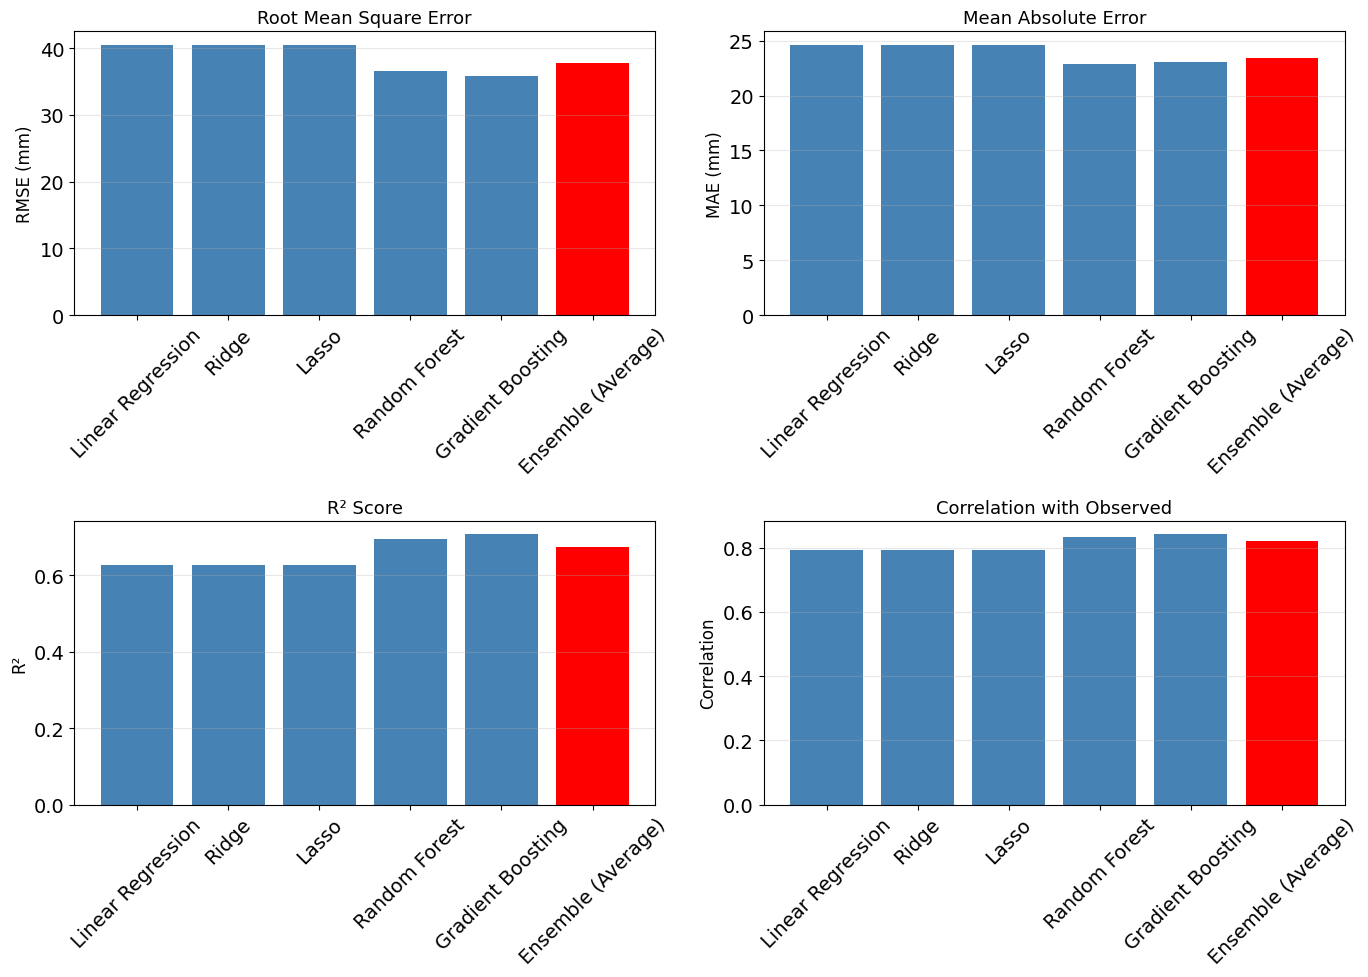

In [71]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Determine colors (ensemble in red, others in steelblue)
colors = ['steelblue'] * len(regression_models) + ['red']

# RMSE
axes[0, 0].bar(regression_results_df['Model'], regression_results_df['RMSE'], color=colors)
axes[0, 0].set_ylabel('RMSE (mm)', fontsize=12)
axes[0, 0].set_title('Root Mean Square Error', fontsize=13)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# MAE
axes[0, 1].bar(regression_results_df['Model'], regression_results_df['MAE'], color=colors)
axes[0, 1].set_ylabel('MAE (mm)', fontsize=12)
axes[0, 1].set_title('Mean Absolute Error', fontsize=13)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# R²
axes[1, 0].bar(regression_results_df['Model'], regression_results_df['R²'], color=colors)
axes[1, 0].set_ylabel('R²', fontsize=12)
axes[1, 0].set_title('R² Score', fontsize=13)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Correlation
axes[1, 1].bar(regression_results_df['Model'], regression_results_df['Correlation'], color=colors)
axes[1, 1].set_ylabel('Correlation', fontsize=12)
axes[1, 1].set_title('Correlation with Observed', fontsize=13)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Scatter Plot: Observed vs Ensemble (Regression)

In [72]:
# Create scatter plot for regression ensemble
fig = px.scatter(
    x=y_test,
    y=ensemble_test,
    labels={
        "x": "Observed Precipitation (mm)",
        "y": "Regression Ensemble Predicted (mm)"
    },
    opacity=0.7,
    color_discrete_sequence=["darkgreen"],
)

fig.update_traces(marker=dict(size=8))

max_limit = max(y_test.max(), ensemble_test.max()) + 50
tick_vals = np.arange(0, max_limit + 1, 50)

fig.update_layout(
    xaxis=dict(range=[0, max_limit], tickvals=tick_vals),
    yaxis=dict(range=[0, max_limit], tickvals=tick_vals),
    width=700,
    height=700,
    title="Observed vs Regression Ensemble",
    margin=dict(l=20, r=20, t=40, b=20),
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)

# Add 1:1 line
fig.add_trace(go.Scatter(
    x=[0, max_limit],
    y=[0, max_limit],
    mode="lines",
    line=dict(color="red", dash="dash"),
    name="1:1 Line",
    showlegend=True
))

fig.show()

### Performance Summary (Regression)

In [73]:
print("="*80)
print("REGRESSION ENSEMBLE PERFORMANCE SUMMARY")
print("="*80)

print(f"\nBest RMSE: {regression_results_df.loc[regression_results_df['RMSE'].idxmin(), 'Model']} "
      f"({regression_results_df['RMSE'].min():.4f} mm)")

print(f"Best MAE: {regression_results_df.loc[regression_results_df['MAE'].idxmin(), 'Model']} "
      f"({regression_results_df['MAE'].min():.4f} mm)")

print(f"Best R²: {regression_results_df.loc[regression_results_df['R²'].idxmax(), 'Model']} "
      f"({regression_results_df['R²'].max():.4f})")

print(f"Best Correlation: {regression_results_df.loc[regression_results_df['Correlation'].idxmax(), 'Model']} "
      f"({regression_results_df['Correlation'].max():.4f})")

print("\n" + "="*80)
print("Full Results Table:")
print("="*80)
print(regression_results_df.to_string(index=False))

REGRESSION ENSEMBLE PERFORMANCE SUMMARY

Best RMSE: Gradient Boosting (35.8694 mm)
Best MAE: Random Forest (22.9133 mm)
Best R²: Gradient Boosting (0.7070)
Best Correlation: Gradient Boosting (0.8413)

Full Results Table:
             Model    RMSE     MAE     R²  Correlation
 Linear Regression 40.5153 24.6148 0.6262       0.7914
             Ridge 40.5153 24.6148 0.6262       0.7914
             Lasso 40.5153 24.6139 0.6262       0.7914
     Random Forest 36.6314 22.9133 0.6944       0.8336
 Gradient Boosting 35.8694 23.0867 0.7070       0.8413
Ensemble (Average) 37.7842 23.4342 0.6749       0.8217


### Compare Gradient Boosting with Individual Precipitation Models

In [74]:
# Prepare test data with same indices for fair comparison
test_indices = regression_data.iloc[X_test.shape[0]*(-1):].index
comparison_data = selected_data.loc[test_indices].copy()

# Add Gradient Boosting predictions to comparison
gb_model = trained_models['Gradient Boosting']
comparison_data['Gradient_Boosting'] = gb_model.predict(X_test)

# Calculate metrics for all models (satellite products + Gradient Boosting)
comparison_models = precip_models + ['Gradient_Boosting']
comparison_results = []

for model in comparison_models:
    valid_data = comparison_data[[observed_col, model]].dropna()
    
    observed = valid_data[observed_col].values
    predicted = valid_data[model].values
    
    # Calculate metrics
    correlation = np.corrcoef(observed, predicted)[0, 1]
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    mae = np.mean(np.abs(observed - predicted))
    r2 = r2_score(observed, predicted)
    bias = np.mean(predicted - observed)
    
    comparison_results.append({
        'Model': model,
        'Correlation': correlation,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Bias': bias
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.round(4)
comparison_df

,Model,Correlation,R²,RMSE,MAE,Bias
0,CHIRPS,0.2942,-17.2956,122.1623,85.8855,79.5798
1,ERA5,0.2862,-6.2351,76.8220,61.0251,59.6987
2,GPM,0.6046,0.2517,24.7063,18.2488,4.9572
3,PERSIANN_CDR,0.3854,-0.2529,31.9682,22.5316,-4.7626
4,TRMM,0.4243,-1.0579,40.9710,27.2686,13.7759
5,TerraClimate,0.5654,-0.0189,28.8285,21.0213,-16.2407
6,Gradient_Boosting,0.0291,-4.5682,67.3940,44.4944,22.5179


### Visualize Comparison: Gradient Boosting vs Precipitation Models

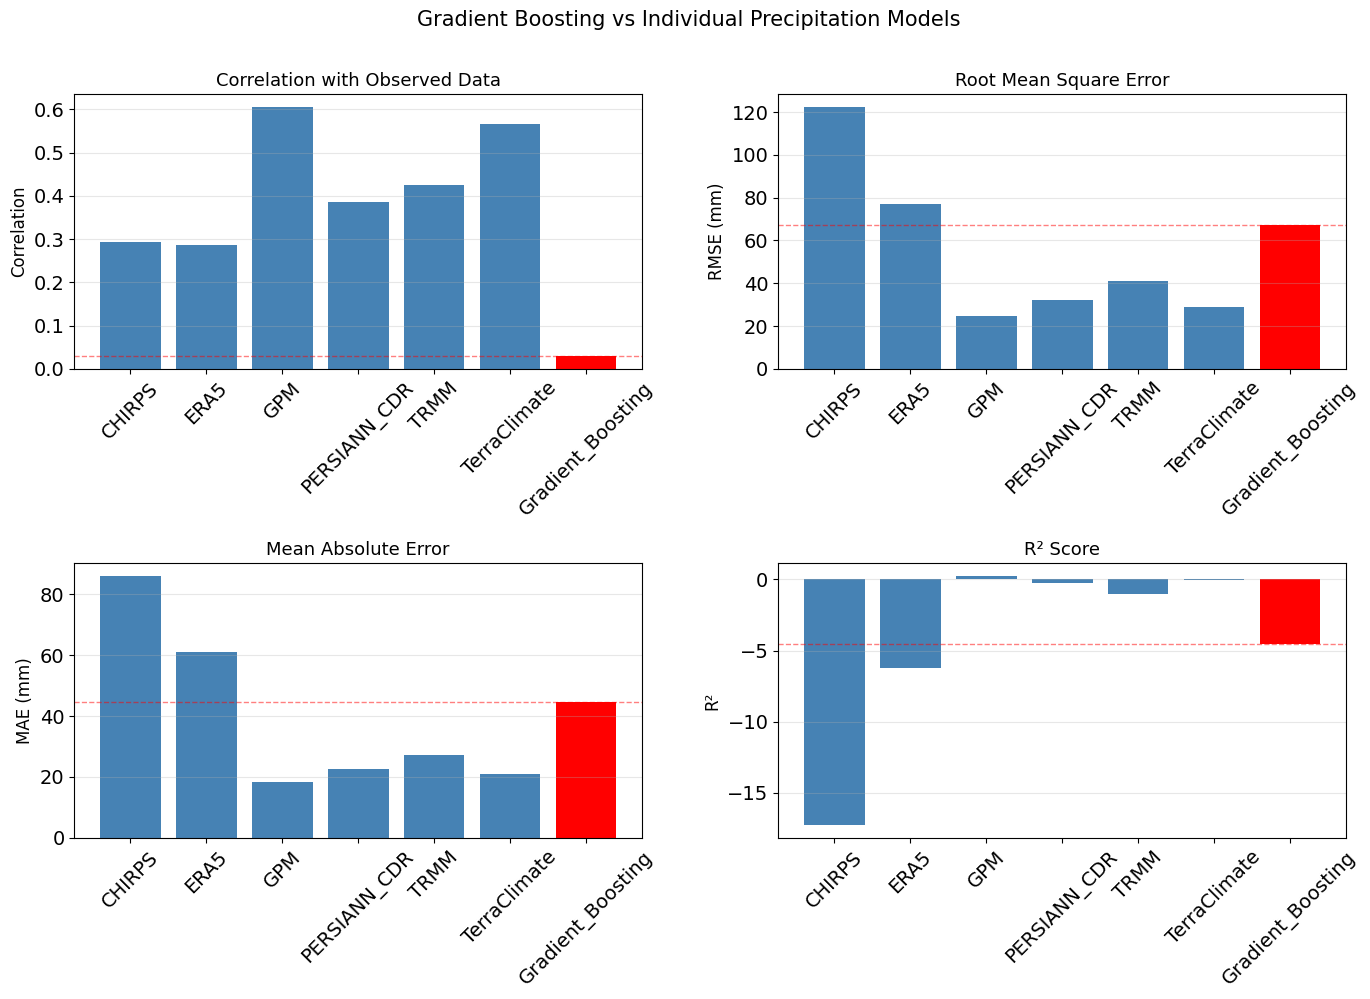

In [75]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Colors: satellite models in steelblue, Gradient Boosting in red
colors = ['steelblue'] * len(precip_models) + ['red']

# Correlation
axes[0, 0].bar(comparison_df['Model'], comparison_df['Correlation'], color=colors)
axes[0, 0].set_ylabel('Correlation', fontsize=12)
axes[0, 0].set_title('Correlation with Observed Data', fontsize=13)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=comparison_df[comparison_df['Model']=='Gradient_Boosting']['Correlation'].values[0], 
                    color='red', linestyle='--', alpha=0.5, linewidth=1)

# RMSE (lower is better)
axes[0, 1].bar(comparison_df['Model'], comparison_df['RMSE'], color=colors)
axes[0, 1].set_ylabel('RMSE (mm)', fontsize=12)
axes[0, 1].set_title('Root Mean Square Error', fontsize=13)
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=comparison_df[comparison_df['Model']=='Gradient_Boosting']['RMSE'].values[0], 
                    color='red', linestyle='--', alpha=0.5, linewidth=1)

# MAE (lower is better)
axes[1, 0].bar(comparison_df['Model'], comparison_df['MAE'], color=colors)
axes[1, 0].set_ylabel('MAE (mm)', fontsize=12)
axes[1, 0].set_title('Mean Absolute Error', fontsize=13)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axhline(y=comparison_df[comparison_df['Model']=='Gradient_Boosting']['MAE'].values[0], 
                    color='red', linestyle='--', alpha=0.5, linewidth=1)

# R²
axes[1, 1].bar(comparison_df['Model'], comparison_df['R²'], color=colors)
axes[1, 1].set_ylabel('R²', fontsize=12)
axes[1, 1].set_title('R² Score', fontsize=13)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].axhline(y=comparison_df[comparison_df['Model']=='Gradient_Boosting']['R²'].values[0], 
                    color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.suptitle('Gradient Boosting vs Individual Precipitation Models', fontsize=15, y=1.00)
plt.tight_layout()
plt.show()

### Taylor Diagram: Gradient Boosting vs Precipitation Models

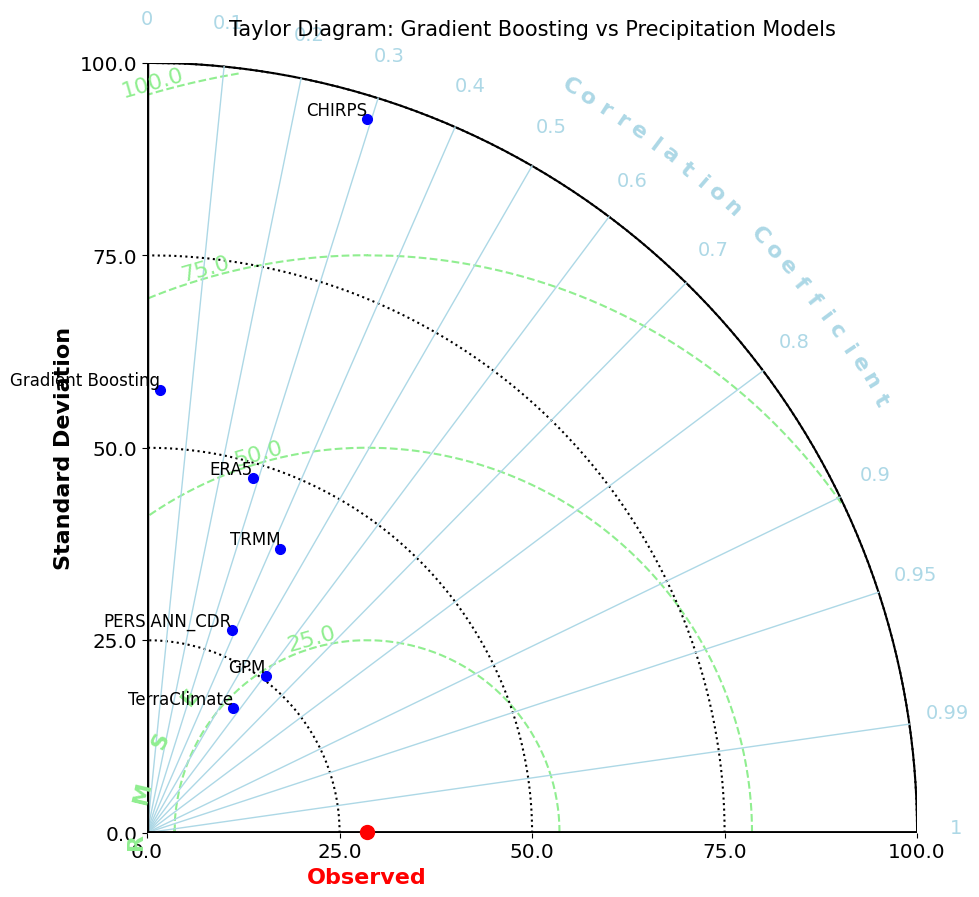

In [76]:
# Prepare data for Taylor diagram
std_mods_comp = []
correlations_comp = []
rmses_comp = []

for model in comparison_models:
    valid_data = comparison_data[[observed_col, model]].dropna()
    
    observed_values = valid_data[observed_col].values
    modeled_values = valid_data[model].values
    
    std_mod = np.std(modeled_values)
    cor = np.corrcoef(observed_values, modeled_values)[0, 1]
    rmse = np.sqrt(np.mean((observed_values - modeled_values) ** 2))
    
    std_mods_comp.append(std_mod)
    correlations_comp.append(cor)
    rmses_comp.append(rmse)

# Add observed data
std_mods_comp.insert(0, np.std(comparison_data[observed_col].dropna()))
rmses_comp.insert(0, 0)
correlations_comp.insert(0, 1)

std_mods_comp = np.array(std_mods_comp)
correlations_comp = np.array(correlations_comp)
rmses_comp = np.array(rmses_comp)

# Create Taylor diagram
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10, 10))

marker_labels_comp = ['Observed'] + precip_models + ['Gradient Boosting']

sm.taylor_diagram(
    std_mods_comp, rmses_comp, correlations_comp,
    markerdisplayed='marker',
    markerLabel=marker_labels_comp,
    markerColor='blue',
    markerSize=14,
    colCOR='lightblue',
    colrms='lightgreen',
    colstd='black',
    styleCOR='-',
    widthCOR=1,
    titleOBS='Observed',
    colOBS='red',
    labelrms="RMSE",
    markerobs='o'
)
plt.title("Taylor Diagram: Gradient Boosting vs Precipitation Models", fontsize=15, pad=20)
plt.show()

### Performance Improvement Summary

In [77]:
# Calculate improvements
gb_metrics = comparison_df[comparison_df['Model']=='Gradient_Boosting'].iloc[0]
satellite_metrics = comparison_df[comparison_df['Model']!='Gradient_Boosting']

print("="*80)
print("GRADIENT BOOSTING vs INDIVIDUAL PRECIPITATION MODELS")
print("="*80)

print("\n" + "Gradient Boosting Performance:".upper())
print("-" * 80)
print(f"Correlation: {gb_metrics['Correlation']:.4f}")
print(f"R²: {gb_metrics['R²']:.4f}")
print(f"RMSE: {gb_metrics['RMSE']:.4f} mm")
print(f"MAE: {gb_metrics['MAE']:.4f} mm")
print(f"Bias: {gb_metrics['Bias']:.4f} mm")

print("\n" + "Best Satellite Model Performance:".upper())
print("-" * 80)
best_satellite = satellite_metrics.loc[satellite_metrics['R²'].idxmax()]
print(f"Model: {best_satellite['Model']}")
print(f"Correlation: {best_satellite['Correlation']:.4f}")
print(f"R²: {best_satellite['R²']:.4f}")
print(f"RMSE: {best_satellite['RMSE']:.4f} mm")
print(f"MAE: {best_satellite['MAE']:.4f} mm")
print(f"Bias: {best_satellite['Bias']:.4f} mm")

print("\n" + "Improvement over Best Satellite Model:".upper())
print("-" * 80)
corr_improve = ((gb_metrics['Correlation'] - best_satellite['Correlation']) / best_satellite['Correlation']) * 100
r2_improve = ((gb_metrics['R²'] - best_satellite['R²']) / best_satellite['R²']) * 100
rmse_improve = ((best_satellite['RMSE'] - gb_metrics['RMSE']) / best_satellite['RMSE']) * 100
mae_improve = ((best_satellite['MAE'] - gb_metrics['MAE']) / best_satellite['MAE']) * 100

print(f"Correlation improvement: {corr_improve:+.2f}%")
print(f"R² improvement: {r2_improve:+.2f}%")
print(f"RMSE improvement: {rmse_improve:+.2f}%")
print(f"MAE improvement: {mae_improve:+.2f}%")

print("\n" + "="*80)
print("\nFull Comparison Table:")
print("="*80)
print(comparison_df.to_string(index=False))

GRADIENT BOOSTING vs INDIVIDUAL PRECIPITATION MODELS

GRADIENT BOOSTING PERFORMANCE:
--------------------------------------------------------------------------------
Correlation: 0.0291
R²: -4.5682
RMSE: 67.3940 mm
MAE: 44.4944 mm
Bias: 22.5179 mm

BEST SATELLITE MODEL PERFORMANCE:
--------------------------------------------------------------------------------
Model: GPM
Correlation: 0.6046
R²: 0.2517
RMSE: 24.7063 mm
MAE: 18.2488 mm
Bias: 4.9572 mm

IMPROVEMENT OVER BEST SATELLITE MODEL:
--------------------------------------------------------------------------------
Correlation improvement: -95.19%
R² improvement: -1914.94%
RMSE improvement: -172.78%
MAE improvement: -143.82%


Full Comparison Table:
            Model  Correlation       R²     RMSE     MAE     Bias
           CHIRPS       0.2942 -17.2956 122.1623 85.8855  79.5798
             ERA5       0.2862  -6.2351  76.8220 61.0251  59.6987
              GPM       0.6046   0.2517  24.7063 18.2488   4.9572
     PERSIANN_CDR      